# Module 2 Final Project Submission

**Student name:** Tiara Hlaing <br>
**Student pace:** Full time <br>
**Project date:** March 2019 <br>
**Instructor name:** Joe San Pietro <br>
**Blog post:** [Query Functions for SQLite](https://thetiaramisu.wordpress.com/2019/03/13/query-functions-for-sqlite/)

***

## Background

The Northwind Traders database was created by Microsoft in 2000 as representation of a fictitious company.

The objective of this project is to use statistical analysis and hypothesis testing on the Northwind database to generate insights and recommendations to the company's executives.

***

## Importing Libaries and Data

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np 

import sqlite3 as sql

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import inspect

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import formula
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

import copy

import warnings
warnings.filterwarnings('ignore')

### Loading the Northwind database

In [2]:
engine = create_engine("sqlite:///Northwind_small.sqlite")
con = engine.connect()
insp = inspect(engine)

In [3]:
def query(statement):
    return pd.read_sql_query(statement, con)

# Function for reading SQL queries into a Pandas dataframe

In [4]:
def table(each):
    statement = "SELECT * FROM ["+each+"];"
    return query(statement)

# Function for making a Pandas dataframe from a whole SQL table

### Previewing the Tables and Their Columns

In [5]:
tables = insp.get_table_names()

tab_cols = []
for each in tables:
    tab_cols.append(table(each).columns)

In [6]:
all_cols = pd.DataFrame(tab_cols)
all_cols = all_cols.T
all_cols.columns = tables
all_cols = all_cols.fillna("--")
all_cols

,Category,Customer,CustomerCustomerDemo,CustomerDemographic,Employee,EmployeeTerritory,Order,OrderDetail,Product,Region,Shipper,Supplier,Territory
0,Id,Id,Id,Id,Id,Id,Id,Id,Id,Id,Id,Id,Id
1,CategoryName,CompanyName,CustomerTypeId,CustomerDesc,LastName,EmployeeId,CustomerId,OrderId,ProductName,RegionDescription,CompanyName,CompanyName,TerritoryDescription
2,Description,ContactName,--,--,FirstName,TerritoryId,EmployeeId,ProductId,SupplierId,--,Phone,ContactName,RegionId
3,--,ContactTitle,--,--,Title,--,OrderDate,UnitPrice,CategoryId,--,--,ContactTitle,--
4,--,Address,--,--,TitleOfCourtesy,--,RequiredDate,Quantity,QuantityPerUnit,--,--,Address,--
5,--,City,--,--,BirthDate,--,ShippedDate,Discount,UnitPrice,--,--,City,--
6,--,Region,--,--,HireDate,--,ShipVia,--,UnitsInStock,--,--,Region,--
7,--,PostalCode,--,--,Address,--,Freight,--,UnitsOnOrder,--,--,PostalCode,--
8,--,Country,--,--,City,--,ShipName,--,ReorderLevel,--,--,Country,--
9,--,Phone,--,--,Region,--,ShipAddress,--,Discontinued,--,--,Phone,--


In [7]:
# Declaring a pandas dataframe variable for each table

categories = table("Category")
customers = table("Customer")
cust_custdemos = table("CustomerCustomerDemo")
demographics = table("CustomerDemographic")
employees = table("Employee")
emp_territories = table("EmployeeTerritory")
orders = table("Order")
order_dets = table("OrderDetail")
products = table("Product")
regions = table("Region")
shippers = table("Shipper")
suppliers = table("Supplier")
territories = table("Territory")

***

## Analysis Questions

As I explore the database, I will address the following questions:
* **Question 1:** Do discounts impact order volume?
* **Question 2:** Do discounts increase revenue?
* **Question 3:** Does customer location impact revenue?
* **Question 4:** Is employee age related to productivity?

In [8]:
# Function to test the Effect Size as Cohen's D

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return print(f"First average = {round(float(group1.mean()),2)}\nSecond average = {round(float(group2.mean()),2)}\nDifference in means = {round(float(diff),2)}\nCohen's d = {round(float(d),2)}")

***

## Question 1: Do discounts impact order volume?

#### Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

As the preview below shows, the Primary ID for the Order Details table is defined as each product in an order. Therefore, to assess the effect of discounts on the order quantity, I will break this question into two hypotheses. One will focus on the order volume for each unique product, and the other will focus on the total order volume for each unique order.

In [9]:
order_dets.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### Difference in order quantities for each product

**H<sub>0</sub>:** The average quantity ordered of each product is the same, whether that product is full priced or discounted.

**H<sub>a</sub>:**  There is a significant different in the average quantity ordered of each product, when that product is full priced as opposed to discounted.

This will be a two-tailed t-test, as the question asks whether discounting a product results in a difference in the average quantity that customers generally order for that product.

In [10]:
# Identifying the products

np.sort(order_dets.ProductId.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77])

In [11]:
# Previewing the average quantity of each product ordered, when discounted vs. full-price

DiscProdAvgQuants = query("SELECT ProductId, AVG(Quantity) as AvgDiscQuantity FROM OrderDetail WHERE Discount != 0 GROUP BY ProductId")
NonDiscProdAvgQuants = query("SELECT ProductId, AVG(Quantity) as AvgNonDiscQuantity FROM OrderDetail WHERE Discount = 0 GROUP BY ProductId")

ProdQuants = DiscProdAvgQuants.join(NonDiscProdAvgQuants.set_index('ProductId'), on='ProductId')
ProdQuants.head()

,ProductId,AvgDiscQuantity,AvgNonDiscQuantity
0,1,27.3125,17.772727
1,2,25.9600,21.473684
2,3,20.0000,28.800000
3,4,28.1000,17.200000
4,5,30.5000,29.333333


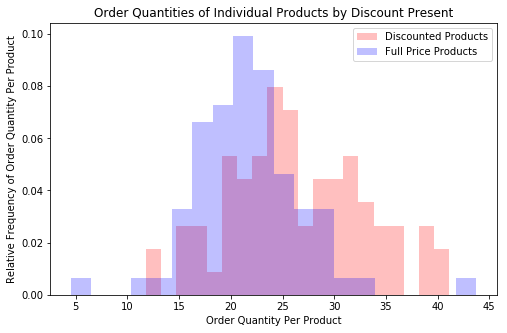

In [12]:
# Visualizing the difference in quantity ordered of individual products, when discounted vs. full-price

plt.figure(figsize=(8,5))
plt.hist(np.array(ProdQuants.AvgDiscQuantity), bins=20, alpha=.25, label="Discounted Products", density=True, color="red")
plt.hist(np.array(ProdQuants.AvgNonDiscQuantity), bins=20, alpha=.25, label="Full Price Products", density=True, color="blue")
plt.title("Order Quantities of Individual Products by Discount Present")
plt.ylabel("Relative Frequency of Order Quantity Per Product")
plt.xlabel("Order Quantity Per Product")
plt.legend()
plt.show()

#### Two-Tailed T-Test

In [13]:
from scipy.stats import ttest_ind
tstat, pval = ttest_ind(ProdQuants.AvgDiscQuantity,ProdQuants.AvgNonDiscQuantity)
print(f"The p-value is: {float(pval)}")

The p-value is: 4.653938937192578e-06


#### Effect Size

In [14]:
Cohen_d(ProdQuants.AvgDiscQuantity,ProdQuants.AvgNonDiscQuantity)

First average = 26.43
Second average = 21.81
Difference in means = 4.62
Cohen's d = 0.77


**Interpreting the Results**: The two-sample t-test returns a significant p-value, far below the alpha level of 0.05. As a result, I will reject the null hypothesis, and accept the alternative hypothesis stating that there is a significant difference between the average quantity of each product ordered depending on whether it is discounted.

Cohen's D shows us that there is quite a significant effect size between the two means. On average, discounting a product increases the quantity of that product by about 5 items.

### Difference in individual order volume with discount present

**H<sub>0</sub>:** The average individual order volume is the same, whether or not the customer's order contains discounted products.

**H<sub>a</sub>:**  There is a significant difference in the average individual order volume, depending on whether or not the order contains any discounted products.

This will be a two-tailed t-test, as the question asks whether the presence of discounted products increases or decreases the average order volume.

In [15]:
disc_grouped = query("SELECT SUM (Quantity) FROM OrderDetail GROUP BY OrderId HAVING SUM (Discount) != 0")
full_grouped = query("SELECT SUM (Quantity) FROM OrderDetail GROUP BY OrderId HAVING SUM (Discount) = 0")

In [16]:
# Previewing the frequency of each order volume for orders containing discounts

disc_grouped["SUM (Quantity)"].value_counts().head(7)

50     20
80     13
30     11
20     10
40      9
100     9
38      7
Name: SUM (Quantity), dtype: int64

In [17]:
# Previewing the frequency of each order volume for full-priced orders

full_grouped["SUM (Quantity)"].value_counts().head(7)

50    18
20    17
10    16
30    12
24    11
32    10
15    10
Name: SUM (Quantity), dtype: int64

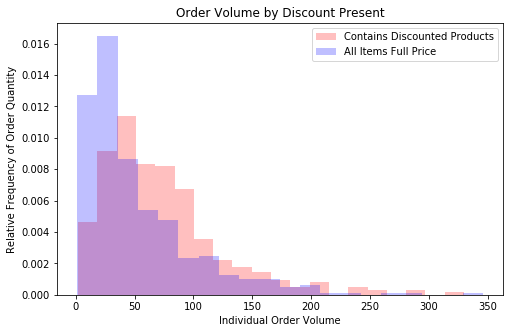

In [18]:
# Visualizing the difference in order volume for orders that are full-priced vs. discounted

plt.figure(figsize=(8,5))
plt.hist(np.array(disc_grouped), bins=20, alpha=.25, label="Contains Discounted Products", density=True, color="red")
plt.hist(np.array(full_grouped), bins=20, alpha=.25, label="All Items Full Price", density=True, color="blue")
plt.title("Order Volume by Discount Present")
plt.ylabel("Relative Frequency of Order Quantity")
plt.xlabel("Individual Order Volume")
plt.legend()
plt.show()

These distributions are quite skewed, so we need to normalize them before performing tests a t-test.

In [19]:
# Log-transforming to normalize

disc_grouped_log = disc_grouped.copy(deep=True)
disc_grouped_log["SUM (Quantity)"] = np.log(disc_grouped_log["SUM (Quantity)"])

full_grouped_log = full_grouped.copy(deep=True)
full_grouped_log["SUM (Quantity)"] = np.log(full_grouped_log["SUM (Quantity)"])

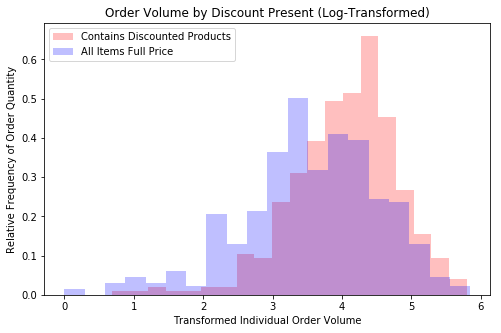

In [20]:
# Visualizing the difference in order volume for orders that are full-priced vs. discounted after log transformation

plt.figure(figsize=(8,5))
plt.hist(np.array(disc_grouped_log), bins=20, alpha=.25, label="Contains Discounted Products", density=True, color="red")
plt.hist(np.array(full_grouped_log), bins=20, alpha=.25, label="All Items Full Price", density=True, color="blue")
plt.title("Order Volume by Discount Present (Log-Transformed)")
plt.ylabel("Relative Frequency of Order Quantity")
plt.xlabel("Transformed Individual Order Volume")
plt.legend()
plt.show()

#### Two-Tailed T-Test

In [21]:
from scipy.stats import ttest_ind
tstat, pval = ttest_ind(disc_grouped_log,full_grouped_log)
print(f"The p-value is: {float(pval)}")

The p-value is: 9.032446365816016e-15


#### Effect Size

In [22]:
Cohen_d(disc_grouped,full_grouped)

First average = 72.94
Second average = 52.44
Difference in means = 20.5
Cohen's d = 0.41


**Interpreting the Results**: The two-sample t-test returns a significant p-value. As a result, I will reject the null hypothesis, and accept the alternative hypothesis stating that there is a significant difference in the average individual order volume when a discounted product is included.

Cohen's D shows us that there is a moderate effect size between the two means. On average, including a discounted product in the order increases the order volume by about 21 items.

### Does the discount level impact order volume?

**H<sub>0</sub>:** The average order volume is the same regardless of the level of the discount applied.

**H<sub>a</sub>:** The average order volume is significantly different depending on the level of the discount applied.

This will be an ANOVA test, as we will be testing the impact of various discount levels on order volume.

In [23]:
disc_quants = query("SELECT Discount, Quantity FROM OrderDetail WHERE Discount != 0")

In [24]:
# Previewing all order quantities for the most frequent discount levels

impdiscs = list(disc_quants.Discount.value_counts()[disc_quants.Discount.value_counts() > 5].index)
disc_quants = disc_quants[disc_quants.Discount.isin(impdiscs)]
disc_quants.head(7)

,Discount,Quantity
0,0.15,35
1,0.15,15
2,0.05,6
3,0.05,15
4,0.05,40
5,0.05,25
6,0.15,15


In [25]:
# Total number of orders per discount level for the most frequent discount levels

disc_tots = query("SELECT Discount, COUNT (Quantity) as TotalOrders FROM OrderDetail WHERE Discount != 0 GROUP BY Discount HAVING AVG (Quantity) > 5")
disc_tots

,Discount,TotalOrders
0,0.05,185
1,0.10,173
2,0.15,157
3,0.20,161
4,0.25,154


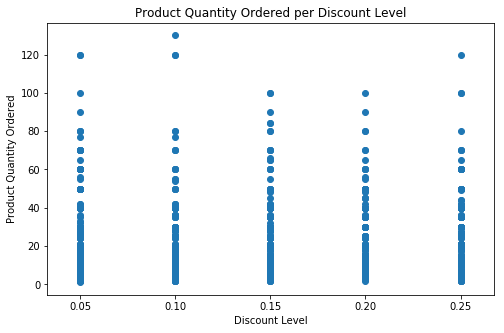

In [26]:
# Visualizing the spread of order size per discount level

plt.figure(figsize=(8,5))
plt.scatter(disc_quants.Discount, disc_quants.Quantity)
plt.title("Product Quantity Ordered per Discount Level")
plt.ylabel("Product Quantity Ordered")
plt.xlabel("Discount Level")
plt.show()

In [27]:
# Average quantity of the discounted product in each order, grouped by discount level

avgperdisc = query("SELECT Discount, AVG (Quantity) as AvgQuantity FROM OrderDetail WHERE Discount != 0 GROUP BY Discount HAVING AVG (Quantity) > 5")
avgperdisc.sort_values("Discount")

,Discount,AvgQuantity
0,0.05,28.010811
1,0.10,25.236994
2,0.15,28.382166
3,0.20,27.024845
4,0.25,28.240260


#### ANOVA Test

In [28]:
formula = 'Quantity ~ C(Discount)'
lm1 = ols(formula, disc_quants).fit()
table1 = sm.stats.anova_lm(lm1, typ=2)
print(table1)

                    sum_sq     df         F    PR(>F)
C(Discount)    1159.517551    4.0  0.674103  0.610041
Residual     354768.342690  825.0       NaN       NaN


**Interpreting the Results**: The ANOVA test returns a high p-value of 0.61, far above the threshold to reject the null hypothesis. As seen above, the average quantity ordered per discount level is very similar across each discount level. These results indicate that the size of the discount has no impact on the quantity of items ordered.

***

## Question 2: Do discounts increase net revenue?

### As a follow up to the previous question: Does the presence of a discount increase the revenue of an order?

**H<sub>0</sub>:** The average net revenue per order is the same regardless of whether or not a discount is present in the order.

**H<sub>a</sub>:** The average net revenue per is greater when a discount is present.

This will be a one-tailed t-test, as I am assuming that an order with a discount present will earn a higher revenue than one without.

_**Calculation for Net Revenue Per Order:** (unitprice x quantity x (1-discount)) summed per order_

In [29]:
# Calculating the net revenue per order, compartimentalized by product

order_rev = copy.copy(order_dets)

orderdetsindexes = list(order_rev.index)
rev_col = []

for i in orderdetsindexes:
    unit = order_dets.UnitPrice[i]
    quant = order_dets.Quantity[i]
    perc = 1 - order_dets.Discount[i]
    rev_col.append(unit * quant * perc)

In [30]:
# Previewing the net revenue per order, compartimentalized by product

order_rev['Revenue'] = rev_col
order_rev.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Revenue
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [31]:
# Previewing the net revenue per order and labeling as discounted or full-priced

rev_df = order_rev.groupby(['OrderId'])['Revenue','Discount'].sum().reset_index()

rev_df['Sale'] = pd.cut(rev_df.Discount,[0.001,1],labels=['Discounted'])
rev_df['Sale'] = rev_df.Sale.cat.add_categories("FullPrice").fillna("FullPrice")

rev_df.drop(['Discount'],axis=1,inplace=True)

rev_df.head()

,OrderId,Revenue,Sale
0,10248,440.00,FullPrice
1,10249,1863.40,FullPrice
2,10250,1552.60,Discounted
3,10251,654.06,Discounted
4,10252,3597.90,Discounted


In [32]:
# Creating separate dataframes for discounted orders and full-priced orders

rev_disc = rev_df[rev_df.Sale == "Discounted"]["Revenue"].reset_index()
rev_full = rev_df[rev_df.Sale == "FullPrice"]["Revenue"].reset_index()

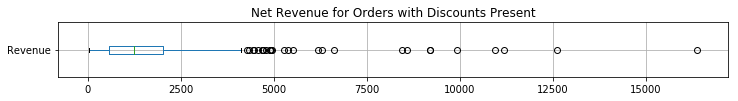

Average Order Net Revenue = $1692.48
Lowest Order Net Revenue = $23.8
Highest Order  Net Revenue = $16387.5


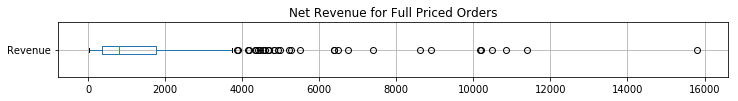

Average Order Net Revenue = $1385.04
Lowest Order Net Revenue = $12.5
Highest Order Net Revenue = $15810.0


In [33]:
# Previewing the distribution of net revenue per order for discounted orders and full-priced orders

rev_disc.boxplot(column='Revenue', vert=False, figsize=(12,1))
plt.title("Net Revenue for Orders with Discounts Present")
plt.show()
print(f'Average Order Net Revenue = ${round(float(rev_disc.Revenue.mean()),2)}')
print(f'Lowest Order Net Revenue = ${round(float(rev_disc.Revenue.min()),2)}')
print(f'Highest Order  Net Revenue = ${round(float(rev_disc.Revenue.max()),2)}')

rev_full.boxplot(column='Revenue', vert=False, figsize=(12,1))
plt.title("Net Revenue for Full Priced Orders")
plt.show()
print(f'Average Order Net Revenue = ${round(float(rev_full.Revenue.mean()),2)}')
print(f'Lowest Order Net Revenue = ${round(float(rev_full.Revenue.min()),2)}')
print(f'Highest Order Net Revenue = ${round(float(rev_full.Revenue.max()),2)}')

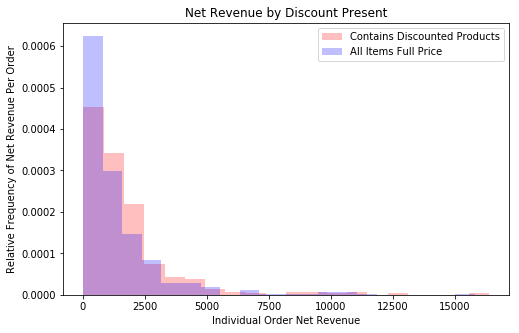

In [34]:
# Visualizing the difference in net revenue for orders that are full-priced vs. including discounted products

plt.figure(figsize=(8,5))
plt.hist(np.array(rev_disc.Revenue), bins=20, alpha=.25, label="Contains Discounted Products", density=True, color="red")
plt.hist(np.array(rev_full.Revenue), bins=20, alpha=.25, label="All Items Full Price", density=True, color="blue")
plt.title("Net Revenue by Discount Present")
plt.ylabel("Relative Frequency of Net Revenue Per Order")
plt.xlabel("Individual Order Net Revenue")
plt.legend()
plt.show()

These distributions are quite skewed, so we need to normalize them before performing tests a t-test.

In [35]:
# Log-transforming to normalize

rev_disc_log = rev_disc.copy(deep=True)
rev_disc_log.Revenue = np.log(rev_disc_log.Revenue)

rev_full_log = rev_full.copy(deep=True)
rev_full_log.Revenue = np.log(rev_full_log.Revenue)

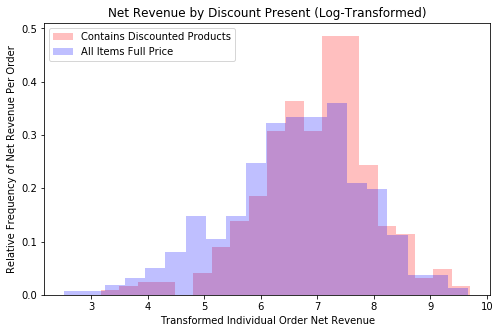

In [36]:
# Visualizing the difference in net revenue for orders that are full-priced vs. including discounted products after log transformation

plt.figure(figsize=(8,5))
plt.hist(np.array(rev_disc_log.Revenue), bins=20, alpha=.25, label="Contains Discounted Products", density=True, color="red")
plt.hist(np.array(rev_full_log.Revenue), bins=20, alpha=.25, label="All Items Full Price", density=True, color="blue")
plt.title("Net Revenue by Discount Present (Log-Transformed)")
plt.ylabel("Relative Frequency of Net Revenue Per Order")
plt.xlabel("Transformed Individual Order Net Revenue")
plt.legend()
plt.show()

#### One-Tailed T-Test

In [37]:
from scipy.stats import ttest_ind
tstat, pval = ttest_ind(rev_disc_log.Revenue,rev_full_log.Revenue)
print(f"The p-value is: {float(pval)/2}")

The p-value is: 8.694440551759886e-07


#### Effect Size

In [38]:
Cohen_d(rev_disc.Revenue,rev_full.Revenue)

First average = 1692.48
Second average = 1385.04
Difference in means = 307.44
Cohen's d = 0.17


**Interpreting the Results**: The one-sample t-test returns a significant p-value. Note that because this was a one-tailed test, the p-value had to be divided by two, because ttest_ind defaults to calculate statistics for a two-tailed test. I will reject the null hypothesis, and accept the alternative hypothesis stating that there is a significant difference in the net revenue for an order when a discounted product is included.

Cohen's D shows us that there is a modest effect size between the two means. On average, including discounted products increases the net revenue per order by $307.44.

***

## Question 3: Does customer location impact revenue?

### Does Northwind receive more expensive orders from certain regions?

**H<sub>0</sub>:** The average revenue per order is the same regardless of the region the orders come from.

**H<sub>a</sub>:** There is a significant difference in the average revenue per order from different regions.

This will be an ANOVA test, as we will be testing the relationship between multiple discount regions and average revenue per order.

In [39]:
# Previewing net revenue per order by region

ordrevs = order_rev.groupby(['OrderId'])['Revenue','Quantity'].sum().reset_index()
ordrevs = pd.concat([ordrevs,orders.ShipRegion],axis=1)
ordrevs.head()

,OrderId,Revenue,Quantity,ShipRegion
0,10248,440.00,27,Western Europe
1,10249,1863.40,49,Western Europe
2,10250,1552.60,60,South America
3,10251,654.06,41,Western Europe
4,10252,3597.90,105,Western Europe


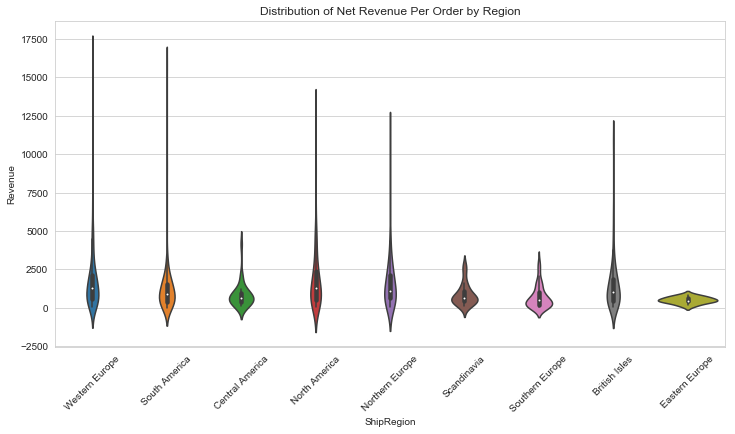

In [40]:
# Visualizing the distribution of net revenue per order for each region

plt.figure(figsize=(12,6))
sns.set_style("whitegrid")
ax = sns.violinplot(x="ShipRegion", y="Revenue", data=ordrevs)
plt.title("Distribution of Net Revenue Per Order by Region")
plt.xticks(rotation=45)
plt.show()

In [41]:
regions = list(ordrevs.ShipRegion.unique())
print(regions)

['Western Europe', 'South America', 'Central America', 'North America', 'Northern Europe', 'Scandinavia', 'Southern Europe', 'British Isles', 'Eastern Europe']


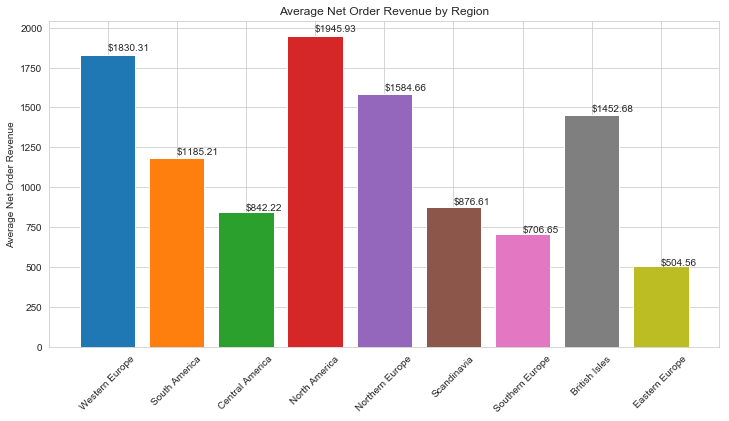

In [42]:
# Visualizing the average net revenue per order by region

plt.figure(figsize=(12,6))

for i in regions:
    y = round(ordrevs[ordrevs.ShipRegion==i]["Revenue"].mean(),2)
    plt.bar(i, y)
    plt.text(i, y*1.015, str(f'${y}'))
    
plt.title('Average Net Order Revenue by Region')
plt.ylabel('Average Net Order Revenue')
plt.xticks(rotation=45)

plt.show()

#### ANOVA Test

In [43]:
formula = 'Revenue ~ C(ShipRegion)'
lm2 = ols(formula, ordrevs).fit()
table2 = sm.stats.anova_lm(lm2, typ=2)
print(table2)

                     sum_sq     df         F        PR(>F)
C(ShipRegion)  1.449610e+08    8.0  5.556116  7.242547e-07
Residual       2.677522e+09  821.0       NaN           NaN


In [44]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     5.556
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           7.24e-07
Time:                        17:42:54   Log-Likelihood:                -7397.2
No. Observations:                 830   AIC:                         1.481e+04
Df Residuals:                     821   BIC:                         1.485e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         1452.6829    208.528      6.966      0.000    1043.372    1861.994
C(ShipRegion)[T.Central America]  -610.4658    399.948     -1.526      0.127   -1395.508     174.576
C(ShipRegion)[T.Eastern Europe]   -948.1186    713.711     -1.328      0.184   -2349.031     452.794
C(ShipRegion)[T.North America]     493.2441    254.833      1.936      0.053      -6.957     993.445
C(ShipRegion)[T.Northern Europe]   131.9746    320.593      0.412      0.681    -497.305     761.254
C(ShipRegion)[T.Scandinavia]      -576.0685    399.948     -1.440      0.150   -1361.110     208.973
C(ShipRegion)[T.South America]    -267.4725    256.857     -1.041      0.298    -771.647     236.702
C(ShipRegion)[T.Southern Europe]  -746.0310    307.314     -2.428      0.015   -1349.244    -142.818
C(ShipRegion)[T.Western Europe]    377.6226    235.160      1.606      0.109     -83.963     839.208
==============================================================================
Omnibus:                      647.062   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12340.531
Skew:                           3.448   Prob(JB):                         0.00
Kurtosis:                      20.587   Cond. No.                         13.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Effect Size

In [45]:
# Calculate Eta-squared
table2['sum_sq']['C(ShipRegion)'] / table2['sum_sq']['Residual']

0.054139984086421365

#### Tukey's Range Test

In [46]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_results = pairwise_tukeyhsd(ordrevs.Revenue, ordrevs.ShipRegion, 0.05)
print(tukey_results)

          Multiple Comparison of Means - Tukey HSD,FWER=0.05          
     group1          group2      meandiff    lower      upper   reject
----------------------------------------------------------------------
 British Isles  Central America -610.4658  -1854.3302  633.3986 False 
 British Isles   Eastern Europe -948.1186  -3167.8036 1271.5664 False 
 British Isles   North America   493.2441  -299.3021  1285.7903 False 
 British Isles  Northern Europe  131.9746  -865.0911  1129.0403 False 
 British Isles    Scandinavia   -576.0685  -1819.9329  667.7959 False 
 British Isles   South America  -267.4725  -1066.3143  531.3693 False 
 British Isles  Southern Europe  -746.031  -1701.7955  209.7334 False 
 British Isles   Western Europe  377.6226  -353.7395  1108.9847 False 
Central America  Eastern Europe -337.6528  -2711.048  2035.7425 False 
Central America  North America  1103.7099   -51.3367  2258.7566 False 
Central America Northern Europe  742.4404   -561.455  2046.3359 False 
Centra

**Interpreting the Results:** The ANOVA test returns a low p-value, allowing us to reject the null hypothesis. Certain regions do seem to purchase more expensive orders than others do. From the Tukey's Range Test, we can specifically see that the significant differences exist between North America and South America, North America and Southern Europe, Western Europe and South America, and Western Europe and Southern Europe. The R-squared value and effect size are very low, indicating that region on its own would not be a good indicator in predicting net revenue for orders. I believe that is due to how few regions actually have a significant difference in order price. The average net revenue generated per order for each region can be seen in the charts and diagrams above.

I am curious to see the comparison between average net revenue per order and the number of orders that have been record for each region, to see if there might be some regions Northwind should focus on marketing more toward. I scaled it slightly to get a more helpful comparison.

In [47]:
regstats = []

for r in regions:
    df_r = ordrevs[ordrevs.ShipRegion==r]
    avgrev = round(df_r["Revenue"].mean(),2)
    numorders = len(ordrevs[ordrevs.ShipRegion==r])
    regstats.append([avgrev,numorders])

In [48]:
reg_df = pd.DataFrame(regstats)
reg_df['Region'] = regions
reg_df.columns = ['AvgRevPerOrder','NumberOfOrders','Region']
reg_df = reg_df[['Region','AvgRevPerOrder','NumberOfOrders']].sort_values("Region")

In [49]:
mn, mx = reg_df["NumberOfOrders"].min(), reg_df["NumberOfOrders"].max()
reg_df["ScaledNumOrders"] = (reg_df["NumberOfOrders"]-mn) / (mx-mn)

mn2, mx2 = reg_df["AvgRevPerOrder"].min(), reg_df["AvgRevPerOrder"].max()
reg_df["ScaledAvgRev"] = (reg_df["AvgRevPerOrder"]-mn2) / (mx2-mn2)

reg_df

,Region,AvgRevPerOrder,NumberOfOrders,ScaledNumOrders,ScaledAvgRev
7,British Isles,1452.68,75,0.252788,0.657791
2,Central America,842.22,28,0.078067,0.234263
8,Eastern Europe,504.56,7,0.000000,0.000000
3,North America,1945.93,152,0.539033,1.000000
4,Northern Europe,1584.66,55,0.178439,0.749357
5,Scandinavia,876.61,28,0.078067,0.258122
1,South America,1185.21,145,0.513011,0.472224
6,Southern Europe,706.65,64,0.211896,0.140207
0,Western Europe,1830.31,276,1.000000,0.919785


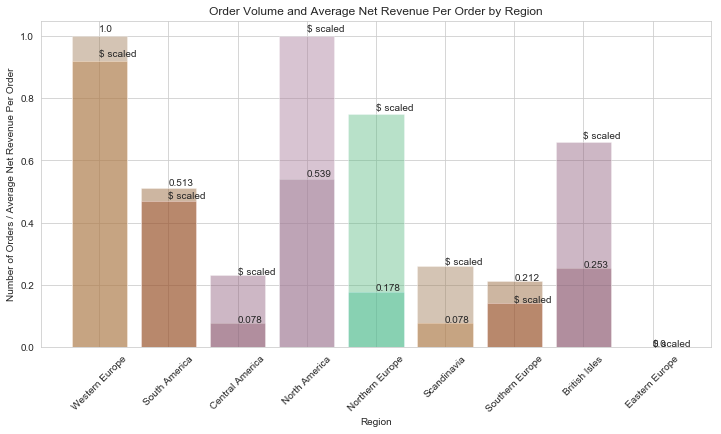

In [50]:
plt.figure(figsize=(12,6))

for i in regions:
    y1 = round(reg_df[reg_df.Region==i]["ScaledNumOrders"].mean(),3)
    y2 = round(reg_df[reg_df.Region==i]["ScaledAvgRev"].mean(),2)
    plt.bar(i, (y1,y2), alpha=0.25)
    plt.bar(i, (y1,y2), alpha=0.25)
    plt.text(i, y1*1.015, str(f'{y1}'))
    plt.text(i, y2*1.015, str(f'$ scaled'))
    
plt.title('Order Volume and Average Net Revenue Per Order by Region')
plt.xlabel('Region')
plt.ylabel('Number of Orders / Average Net Revenue Per Order')
plt.xticks(rotation=45)

plt.show()

From a glance, some observations can be made about the relationship between the order volume and the average price per order for each region that Northwind ships to. Western Europe has been a great region for business, as they spend tend a relatively high amount per order compared to other regions, and they have made the most orders.

North America on average spends the most on each order, however they account for just over half as many orders as Western Europe does. Northern Europe similarly spends the next highest amount per order, but they account for far fewer of the recorded sales.

***

## Question 4: Is employee age related to productivity?

### Does the number of sales per year vary by the age of the employees?

**H<sub>0</sub>:** The average number of sales per year is the same for all employee ages.

**H<sub>a</sub>:** There is a significant difference in the number of sales per year for employees of different ages.

This will be an ANOVA test, as we will be testing the relationship between various employee ages and the average number of sales per year.

In [51]:
employees.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [52]:
# Collecting the birthdate for each employee and changing to datetime format

emp_ages = employees[["Id","BirthDate"]]
emp_ages['BirthDate'] = pd.to_datetime(emp_ages['BirthDate'])
emp_ages['BirthYear'] = emp_ages['BirthDate'].dt.year


emp_ages

,Id,BirthDate,BirthYear
0,1,1980-12-08,1980
1,2,1984-02-19,1984
2,3,1995-08-30,1995
3,4,1969-09-19,1969
4,5,1987-03-04,1987
5,6,1995-07-02,1995
6,7,1992-05-29,1992
7,8,1990-01-09,1990
8,9,1998-01-27,1998


In [53]:
# Calculating age for each employee, from birth year

emp_ages['Age']=np.ones(9)
for i in range(0,9):
    emp_ages['Age'][i] = 2019-emp_ages['BirthYear'][i]
emp_ages = emp_ages[["Id","Age"]]
emp_ages

,Id,Age
0,1,39.0
1,2,35.0
2,3,24.0
3,4,50.0
4,5,32.0
5,6,24.0
6,7,27.0
7,8,29.0
8,9,21.0


In [54]:
# Collecting data on orders by employee. Changing shipped date to datetime format

emp_orders = orders[["Id","EmployeeId","ShippedDate"]]
emp_orders['ShippedDate'] = pd.to_datetime(emp_orders['ShippedDate'])
emp_orders['ShippedYear'] = emp_orders['ShippedDate'].dt.year

In [55]:
# Only looking at the year each order was shipped (the year each sale was made)

emp_orders = emp_orders[['EmployeeId','ShippedYear']].sort_values("EmployeeId")
emp_orders.dropna(inplace=True)
emp_orders.head()

,EmployeeId,ShippedYear
139,1,2012.0
587,1,2014.0
586,1,2014.0
145,1,2013.0
146,1,2013.0


In [56]:
# Previewing how many sales were made per employee across all 3 years

emp_orders.EmployeeId.value_counts().sort_index()

1    120
2     93
3    127
4    151
5     42
6     65
7     69
8    100
9     42
Name: EmployeeId, dtype: int64

In [57]:
# Previewing how many sales there were per year

emp_orders.ShippedYear.value_counts().sort_index()

2012.0    143
2013.0    398
2014.0    268
Name: ShippedYear, dtype: int64

In [58]:
emp_orders = emp_orders.groupby(['EmployeeId','ShippedYear']).size().reset_index()
emp_orders["Age"] = emp_orders["EmployeeId"]
emp_orders.columns = ['EmployeeId','ShippedYear','Sales','Age']
emp_orders.head()

,EmployeeId,ShippedYear,Sales,Age
0,1,2012.0,23,1
1,1,2013.0,56,1
2,1,2014.0,41,1
3,2,2012.0,14,2
4,2,2013.0,41,2


In [59]:
# Adding employee age to table of orders by each employee per year

for i in range(len(emp_orders)):
    for k in emp_ages.Id.unique():
        if emp_orders["EmployeeId"][i] == k:
            emp_orders["Age"][i] = emp_ages["Age"].loc[emp_ages.Id==k]

In [60]:
emp_orders.head()

,EmployeeId,ShippedYear,Sales,Age
0,1,2012.0,23,39
1,1,2013.0,56,39
2,1,2014.0,41,39
3,2,2012.0,14,35
4,2,2013.0,41,35


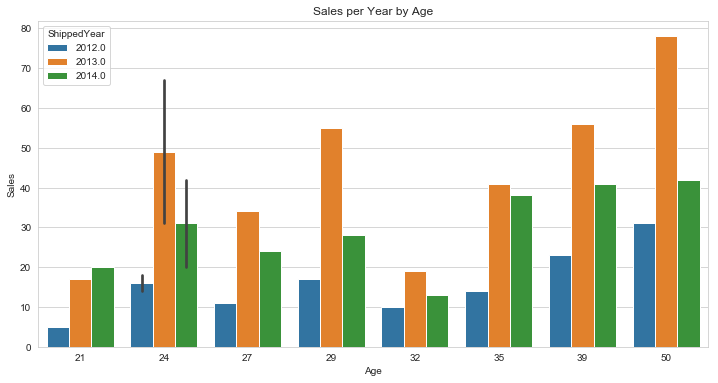

In [61]:
# Sales per year per employee age

plt.figure(figsize=(12,6))
sns.barplot(x="Age",y="Sales",hue="ShippedYear",data=emp_orders)
plt.title("Sales per Year by Age")
plt.show()

In [62]:
emp_orders = emp_orders.groupby(['EmployeeId'])['Sales'].mean().reset_index()

In [63]:
# Calculating the average number of sales per year for each employee age

empSalesPerAge = pd.concat([emp_ages.Age,emp_orders.Sales],axis=1)
empSalesPerAge = empSalesPerAge.groupby(['Age'])['Sales'].mean().reset_index().sort_values("Age")
empSalesPerAge

,Age,Sales
0,21.0,14.000000
1,24.0,32.000000
2,27.0,23.000000
3,29.0,33.333333
4,32.0,14.000000
5,35.0,31.000000
6,39.0,40.000000
7,50.0,50.333333


In [64]:
empSalesPerAge.Age.unique()

array([21., 24., 27., 29., 32., 35., 39., 50.])

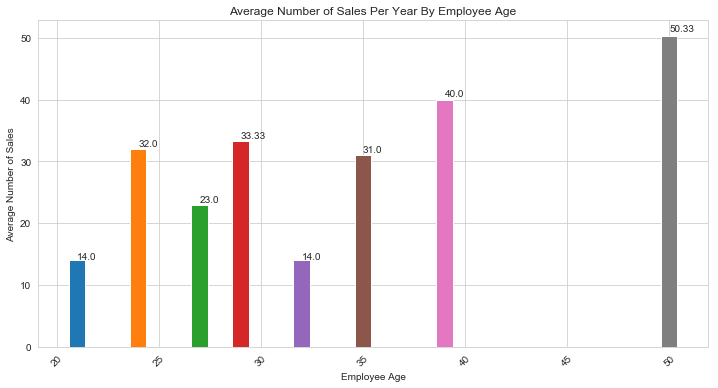

In [65]:
# Average sales per year by employee age

plt.figure(figsize=(12,6))

for i in empSalesPerAge.Age.unique():
    y = round(empSalesPerAge[empSalesPerAge.Age==i]["Sales"].mean(),2)
    plt.bar(i, y)
    plt.text(i, y*1.015, str(f'{y}'))
    
plt.title('Average Number of Sales Per Year By Employee Age')
plt.xlabel('Employee Age')
plt.ylabel('Average Number of Sales')
plt.xticks(rotation=45)

plt.show()

#### Anova Test

In [66]:
formula = 'Sales ~ Age'
lm3 = ols(formula, empSalesPerAge).fit()
table3 = sm.stats.anova_lm(lm3, typ=2)
table3

,sum_sq,df,F,PR(>F)
Age,648.620903,1.0,8.819692,0.024964
Residual,441.254097,6.0,NaN,NaN


In [67]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     8.820
Date:                Mon, 22 Apr 2019   Prob (F-statistic):             0.0250
Time:                        17:42:57   Log-Likelihood:                -27.392
No. Observations:                   8   AIC:                             58.78
Df Residuals:                       6   BIC:                             58.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6686     11.641     -0.315      0.763     -32.152      24.815
Age            1.0390      0.350      2.970      0.025       0.183       1.895
==============================================================================
Omnibus:                        2.546   Durbin-Watson:                   2.624
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                0.635
Skew:                          -0.689   Prob(JB):                        0.728
Kurtosis:                       3.074   Cond. No.                         128.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpreting the Results:** The ANOVA test returns a significant p-value, allowing us to reject the null hypothesis. The R-squared value for this test is moderately high, meaning it is reasonable to accept the alternative hypothesis that the age of the employee has a relationship with the number of sales.

From the bar graph above, which broke down the average yearly sales by age, there does seems to be a general positive correlation between age and average annual sales. The 21-year-old  The 50-year-old employee is significantly older than most of the other employees, and he also averages significantly higher annual sales than his colleagues.

It is noteworthy, however, that the 21-year-old started with just 5 total sales in 2012 and significantly increased his number of sales in the subsequent years. This could be due to him starting his new job with the company in 2012 and learning the role. Additionally, it is encouraging to see the progress he made over those three years, indicating the potential to continue growing in his role.

2013 particularly seems to have been a great year for sales across all employees, as Northwind netted more sales that year than they did in 2012 or 2014. The number of sales fell from 2013 to 2014 for all employees except the 21-year-old.

***

## Conclusion

### Summary of Results

To recap, the four questions I sought to answer were:
1. Do discounts impact order volume?
2. Do discounts increase revenue?
3. Does customer location impact revenue?
4. Is employee age related to productivity?

From my analysis in regard to these questions, I made the following observations:
* The presence of a discount makes a significant difference in the quantity of products ordered
    * True for orders containing at least one discounted item, but especially true when comparing the quantity sold for one product when it was discount vs. not
* The discount level does not have a significant impact on the order volume
* The presence of a discount makes a significant positive impact on the revenue per order
    * Average difference = &#36;307.44 more for discounted products
* The average revenue from sales does appear to differ amongst the different regions 
    * Based on significant differences found between a limited number of regions
    * Western Europe, North America, and Northern Europe spend the most per order
    * North America has purchased about half as many orders as Western Europe
    * Northern Europe has purchased about ⅕ as many orders as Western Europe
* Age does appear to have a general positive correlation with average annual sales

### Business Recommendations

1. **Highlight discounts**: sales entice customers to buy more
    * Seeing as how a higher level discount doesn't necessarily increase sales over lower level discounts, I suggest going with a minimal discount most times, for maximum profit<br><br>
2. **Rotate the discounts**: keeping the same product discounted over time will likely lessen the appeal of that specific product's discount<br><br>
3. **Require a purchase minimum for discounts**
    * E.g. offer 5% off the total price for an order with at least 85 full-priced products
    * E.g. offer 5% off the total price for an order that costs at least &#36;1,500<br><br>
4. **Focus marketing energy and resources on certain regions**
    * Keep advertising in Western Europe
    * Give more attention to expand business North America and Northern Europe to increase sales in these high-profit regions<br><br>
5. **Consider employee age**
    * Invest in young employees, as they generally have the drive to improve quickly in their first few years of work
    * Reward employees on reaching milestones for their work experience to retain them, as their performance seems to generally increase with age



### Future Work

Questions to consider for additional research:

* Focus more on calculating gross profit
    * Factor in cost of supplies, production, and shipping
* Do more thorough research on company location
    * E.g. How many countries per region? Trends amongst countries within a region?
* Are customers from different regions/countries more likely to purchase certain products over others?
* Assess employee productivity by length of time at company
    * Current roadblock: The hire dates were set to years in the future, so I wasn't sure how to determine length of employment
* Understand that research on employee age is limited due to small sample size
* Do more research on other parties involved besides customers and employees
    * E.g. Suppliers? Shippers?
* Investigate what made 2013 such a profitable year compared to 2012 and 2014